# SNSCRAPE

## tokenizer & stemmer

In [2]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [3]:
media_results_csv = pd.read_csv('processed twitter data/media_results.csv')
creator_results_csv = pd.read_csv('processed twitter data/creator_results.csv')
general_results_csv = pd.read_csv('processed twitter data/general_results.csv')
vogue_results_csv = pd.read_csv('processed twitter data/vogue_results.csv')
compiler_results_csv = pd.read_csv('processed twitter data/compiler_results.csv')

In [4]:
media_results_list = media_results_csv['Processed'].tolist()
creator_results_list = creator_results_csv['Processed'].tolist()
general_results_list = general_results_csv['Processed'].tolist()
vogue_results_list = vogue_results_csv['Processed'].tolist()
compiler_results_list = compiler_results_csv['Processed'].tolist()

In [4]:
media_results_list

['launches frequent brands including gucci adidas launching according new data retail consumers across uk us still unaware applications benefits',
 'launches frequent brands like launching according new data consumers uk us still unaware applications benefits story',
 'positioned physical influencer creator hub 1 2 million square foot emcee studio opening downtown l later part emcees expansion',
 'marketers discussed ways among topics digiday medias cmo summit',
 'positioned physical influencer creator hub 1 2 million square foot emcee studio opening downtown l later part emcees expansion story',
 'latest hire styling track record daphne guinness story',
 'delving skin market collection marries utility luxury design move suggests could become go path industry veterans story',
 'january dtc underwear brand meundies posted twitter joined collection bored ape yacht club reaction company received less positive story',
 'complete influencers product launches branded beauty event come story'

In [5]:
tokenizer = RegexpTokenizer(r'\w+')

media_words = []
creator_words = []
general_words = []
compiler_words = []
vogue_words = []

for tweet_text in media_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        media_words.append(tokens)

In [6]:
for tweet_text in creator_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        creator_words.append(tokens)

In [7]:
for tweet_text in general_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        general_words.append(tokens)

In [8]:
for tweet_text in compiler_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        compiler_words.append(tokens)

In [9]:
for tweet_text in vogue_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        vogue_words.append(tokens)

In [10]:
print(len(media_words))
print(len(creator_words))
print(len(general_words))
print(len(compiler_words))
print(len(vogue_words))

1039
3343
24947
58
55


In [22]:
media_words

[['launches',
  'frequent',
  'brands',
  'including',
  'gucci',
  'adidas',
  'launching',
  'according',
  'new',
  'data',
  'retail',
  'consumers',
  'across',
  'uk',
  'us',
  'unaware',
  'applications',
  'benefits'],
 ['launches',
  'frequent',
  'brands',
  'like',
  'launching',
  'according',
  'new',
  'data',
  'consumers',
  'uk',
  'us',
  'unaware',
  'applications',
  'benefits',
  'story'],
 ['positioned',
  'physical',
  'influencer',
  'creator',
  'hub',
  '1',
  '2',
  'million',
  'square',
  'foot',
  'emcee',
  'studio',
  'opening',
  'downtown',
  'l',
  'later',
  'part',
  'emcees',
  'expansion'],
 ['marketers',
  'discussed',
  'ways',
  'among',
  'topics',
  'digiday',
  'medias',
  'cmo',
  'summit'],
 ['positioned',
  'physical',
  'influencer',
  'creator',
  'hub',
  '1',
  '2',
  'million',
  'square',
  'foot',
  'emcee',
  'studio',
  'opening',
  'downtown',
  'l',
  'later',
  'part',
  'emcees',
  'expansion',
  'story'],
 ['latest',
  'hir

In [404]:
stopwords_LDA = ["go","m","pm","look","soon","start","let","yet","full","still","good","know","much", "well", 
                 "wait","try","thank","dm","lol","hit","put","ve","send","give","going","dude","stuff","get","got","l","p","10",
                 "co","gm","b","haha","work","many","hard","thing","make","next","come","fam","even","gt","1","2","3","4","5","6","7","8","9","pst",
                 "cet","est","wont","irl","100","u","x","via","hey","w","utc","worldhealthday2021","0","may","000","00","12","yes","30","24","et","1155",
                "50","20","im","15","e","7pm","vs","6pm","28","z","3pm","721","12pm","2nd","16","11","13","af","oh","17","thats","rt","30pm","8pm","21",
                 "theres","11am","17th","26","5pm","lp","youll","check","like","today","part","ever","need","every","lets","already","twitter",
                 "use","sure","something","please","tomorrow","us","see","across","pode","matic","way","fine","stay","nhs","within","might","10th",
                 "wanna","18","101","etc","per","says","came","sorry","thanks","including","another","set","able","back","left","become","gonna",
                 "comes","tonight","end","must","done","true","working","guys","never","seen","else","actually","retweet","really","200","23",
                "whose","ways","goo","led","appears","lil","till","wow","tweet","week","get","hope"]

In [411]:
from collections import Counter
from collections import OrderedDict
counted = Counter(list1)
sorted_by_count = counted.most_common()
sorted_by_count

[('fashion', 869),
 ('digital', 546),
 ('new', 402),
 ('digitalax', 381),
 ('collection', 358),
 ('mona', 336),
 ('web3', 275),
 ('world', 235),
 ('drop', 227),
 ('physical', 225),
 ('virtual', 213),
 ('digitalfashion', 211),
 ('marketplace', 199),
 ('exclusive', 198),
 ('future', 196),
 ('art', 193),
 ('live', 185),
 ('join', 176),
 ('auction', 174),
 ('space', 172),
 ('read', 169),
 ('available', 161),
 ('holders', 156),
 ('jewelry', 151),
 ('digifizzy', 148),
 ('community', 146),
 ('gaming', 146),
 ('content', 145),
 ('time', 136),
 ('rarible', 136),
 ('blockchain', 134),
 ('piece', 132),
 ('brand', 127),
 ('brands', 123),
 ('discord', 120),
 ('sold', 118),
 ('game', 113),
 ('crypto', 110),
 ('open', 110),
 ('launch', 108),
 ('platform', 106),
 ('dropped', 104),
 ('excited', 104),
 ('love', 102),
 ('rtfkt', 100),
 ('ethereum', 100),
 ('big', 97),
 ('want', 97),
 ('network', 92),
 ('designer', 91),
 ('ready', 90),
 ('coming', 90),
 ('artist', 88),
 ('magazine', 87),
 ('help', 84),
 (

In [405]:
for i in media_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [406]:
for i in creator_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [407]:
all_words = media_words+creator_words

In [408]:
all_words

[['launches',
  'frequent',
  'brands',
  'gucci',
  'adidas',
  'launching',
  'according',
  'new',
  'data',
  'retail',
  'consumers',
  'uk',
  'unaware',
  'applications',
  'benefits'],
 ['launches',
  'frequent',
  'brands',
  'launching',
  'according',
  'new',
  'data',
  'consumers',
  'uk',
  'unaware',
  'applications',
  'benefits',
  'story'],
 ['positioned',
  'physical',
  'influencer',
  'creator',
  'hub',
  'million',
  'square',
  'foot',
  'emcee',
  'studio',
  'opening',
  'downtown',
  'later',
  'emcees',
  'expansion'],
 ['marketers',
  'discussed',
  'among',
  'topics',
  'digiday',
  'medias',
  'cmo',
  'summit'],
 ['positioned',
  'physical',
  'influencer',
  'creator',
  'hub',
  'million',
  'square',
  'foot',
  'emcee',
  'studio',
  'opening',
  'downtown',
  'later',
  'emcees',
  'expansion',
  'story'],
 ['latest',
  'hire',
  'styling',
  'track',
  'record',
  'daphne',
  'guinness',
  'story'],
 ['delving',
  'skin',
  'market',
  'collectio

In [409]:
string1 = ''
for i in all_words:
    for j in i:
        string1 += j+" "
print("done")

done


In [410]:
list1 = string1.split()
list1

['launches',
 'frequent',
 'brands',
 'gucci',
 'adidas',
 'launching',
 'according',
 'new',
 'data',
 'retail',
 'consumers',
 'uk',
 'unaware',
 'applications',
 'benefits',
 'launches',
 'frequent',
 'brands',
 'launching',
 'according',
 'new',
 'data',
 'consumers',
 'uk',
 'unaware',
 'applications',
 'benefits',
 'story',
 'positioned',
 'physical',
 'influencer',
 'creator',
 'hub',
 'million',
 'square',
 'foot',
 'emcee',
 'studio',
 'opening',
 'downtown',
 'later',
 'emcees',
 'expansion',
 'marketers',
 'discussed',
 'among',
 'topics',
 'digiday',
 'medias',
 'cmo',
 'summit',
 'positioned',
 'physical',
 'influencer',
 'creator',
 'hub',
 'million',
 'square',
 'foot',
 'emcee',
 'studio',
 'opening',
 'downtown',
 'later',
 'emcees',
 'expansion',
 'story',
 'latest',
 'hire',
 'styling',
 'track',
 'record',
 'daphne',
 'guinness',
 'story',
 'delving',
 'skin',
 'market',
 'collection',
 'marries',
 'utility',
 'luxury',
 'design',
 'move',
 'suggests',
 'could',
 'p

In [389]:
for i in general_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [390]:
for i in compiler_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)

In [391]:
for i in vogue_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


## LDA Topic Modelling 2

In [67]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
#import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.gensim as gensimvis

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [68]:
gensim.__version__

'4.1.2'

## media and creator combined LDA

In [418]:
# Build the bigram and trigram models
all_bigram = gensim.models.Phrases(all_words, min_count=5, threshold=100) # higher threshold fewer phrases.
all_trigram = gensim.models.Phrases(all_bigram[all_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
all_bigram_mod = gensim.models.phrases.Phraser(all_bigram)
all_trigram_mod = gensim.models.phrases.Phraser(all_trigram)

In [419]:
def make_bigrams6(texts):
    return [all_bigram_mod[doc] for doc in texts]

def make_trigrams6(texts):
    return [all_trigram_mod[all_bigram_mod[doc]] for doc in texts]

In [420]:
all_bigrams = make_bigrams6(all_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

all_lemmatized = lemmatization(all_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [421]:
# Create Dictionary
all_id2word = corpora.Dictionary(all_lemmatized)

# Create Corpus
all_texts = all_lemmatized

# Term Document Frequency
all_corpus = [all_id2word.doc2bow(text) for text in all_texts]

In [423]:
all_topics = []
all_perplexity_score = []
all_coherence_score = []
all_vis = []

for i in range(3,11):
    all_lda_model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,
                                           id2word=all_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    all_topics.append(all_lda_model.show_topics(num_topics=i,num_words=20))
    
    all_perplexity_score.append(all_lda_model.log_perplexity(all_corpus))
    
    coherence_model_lda = CoherenceModel(model=all_lda_model, texts=all_lemmatized, dictionary=all_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    all_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(all_lda_model, all_corpus, all_id2word)
    all_vis.append(vis_i)

In [424]:
all_topics

[[(0,
   '0.022*"love" + 0.020*"available" + 0.015*"custom" + 0.013*"new" + 0.012*"brand" + 0.012*"rarible" + 0.011*"exclusive" + 0.010*"ready" + 0.010*"buy" + 0.009*"support" + 0.009*"mona" + 0.008*"create" + 0.008*"collectible" + 0.008*"crypto" + 0.007*"marketplace" + 0.007*"holder" + 0.007*"sale" + 0.007*"purchase" + 0.007*"take" + 0.007*"hour"'),
  (1,
   '0.024*"physical" + 0.023*"digitalax" + 0.018*"want" + 0.015*"owner" + 0.014*"collector" + 0.013*"mint" + 0.011*"join" + 0.010*"edition" + 0.009*"look" + 0.008*"link" + 0.007*"tier" + 0.007*"special" + 0.006*"discord" + 0.006*"amazing" + 0.006*"beautiful" + 0.006*"keep" + 0.006*"talk" + 0.006*"get" + 0.006*"skin" + 0.005*"happen"'),
  (2,
   '0.033*"jewelry" + 0.027*"collection" + 0.023*"piece" + 0.023*"digital" + 0.021*"drop" + 0.017*"fashion" + 0.014*"art" + 0.011*"auction" + 0.010*"future" + 0.010*"world" + 0.009*"sell" + 0.009*"think" + 0.009*"community" + 0.009*"make" + 0.008*"big" + 0.008*"live" + 0.008*"space" + 0.007*"desi

In [461]:
all_vis[6]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.397170  0.002916       1        1  18.215468
8      0.061165 -0.032505       2        1  12.460412
0      0.058270 -0.029297       3        1  11.816178
4      0.057533  0.312961       4        1  11.082145
1      0.052483 -0.249329       5        1  10.669394
6      0.045733  0.027117       6        1  10.159657
3      0.039057 -0.009444       7        1   9.756441
2      0.043755 -0.012949       8        1   8.660650
7      0.039175 -0.009470       9        1   7.179655, topic_info=            Term        Freq       Total Category  logprob  loglift
35    collection  562.000000  562.000000  Default  30.0000  30.0000
5033     jewelry  707.000000  707.000000  Default  29.0000  29.0000
250         drop  404.000000  404.000000  Default  28.0000  28.0000
448        piece  397.000000  397.000000  Default  27.0000  27.0000
109      digital  490.000000  490.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2347         lfg   20.131250   21.202159   Topic9  -4.9898   2.5821
2938       chill   19.733975   20.805833   Topic9  -5.0097   2.5810
1564    ethereum   19.619464   20.690120   Topic9  -5.0155   2.5808
1796        card   19.383592   20.454444   Topic9  -5.0276   2.5801
2081      family   19.366258   20.437060   Topic9  -5.0285   2.5801

[305 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
561       2  0.970314   access
556       5  0.973072      add
2471      6  0.973935  airdrop
2003      3  0.987576   always
2422      6  0.985141  amazing
...     ...       ...      ...
1238      5  0.967467     wild
660       7  0.975458      win
85        9  0.984860     work
76        1  0.992951    world
116       3  0.966604    worth

[277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 1, 5, 2, 7, 4, 3, 8])

In [ ]:
pyLDAvis.save_html(all_vis[2], 'all_lda_vis_5 topic.html')

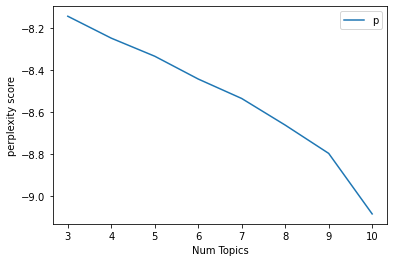

In [426]:
import matplotlib.pyplot as plt

limit=3+len(all_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, all_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

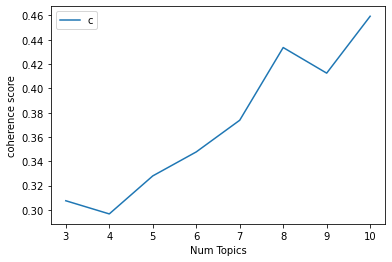

In [427]:
limit=3+len(all_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, all_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## ALL - 5 topic model

In [428]:
topic_1 = []
topic_1_string = ''

topic_2 = []
topic_2_string = ''

topic_3 = []
topic_3_string = ''

topic_4 = []
topic_4_string = ''

topic_5 = []
topic_5_string = ''

check1 = all_topics[2][0][1].split("\"")
check1 = [s.rstrip("*").lstrip(" + ") for s in check1]

check2 = all_topics[2][1][1].split("\"")
check2 = [s.rstrip("*").lstrip(" + ") for s in check2]

check3 = all_topics[2][2][1].split("\"")
check3 = [s.rstrip("*").lstrip(" + ") for s in check3]

check4 = all_topics[2][3][1].split("\"")
check4 = [s.rstrip("*").lstrip(" + ") for s in check4]

check5 = all_topics[2][4][1].split("\"")
check5 = [s.rstrip("*").lstrip(" + ") for s in check5]

In [429]:
for i in range(20):
    topic_1.append((check1[(i*2)+1],check1[i*2]))
    topic_1_string += check1[(i*2)+1]
    topic_1_string += " "
    
    topic_2.append((check2[(i*2)+1],check2[i*2]))
    topic_2_string += check2[(i*2)+1]
    topic_2_string += " "
    
    topic_3.append((check3[(i*2)+1],check3[i*2]))
    topic_3_string += check3[(i*2)+1]
    topic_3_string += " "
    
    topic_4.append((check4[(i*2)+1],check4[i*2]))
    topic_4_string += check4[(i*2)+1]
    topic_4_string += " "
    
    topic_5.append((check5[(i*2)+1],check5[i*2]))
    topic_5_string += check5[(i*2)+1]
    topic_5_string += " "

In [430]:
print("These are the words for 5 topics")
print("Perplexity score for 5-Topic model: ",all_perplexity_score[2])
print("Coherence score for 5-Topic model: ",all_coherence_score[2])
print(" ")
print("Topic 1: ",topic_1_string)
print(" ")
print("Topic 2: ",topic_2_string)
print(" ")
print("Topic 3: ",topic_3_string)
print(" ")
print("Topic 4: ",topic_4_string)
print(" ")
print("Topic 5: ",topic_5_string)

These are the words for 5 topics
Perplexity score for 5-Topic model:  -8.334351652103265
Coherence score for 5-Topic model:  0.32793696105231396
 
Topic 1:  jewelry collection drop future make collectible live liftoff space cryptojeweler rarible mint begin buy real support create crypto people collect 
 
Topic 2:  piece art auction want available blockchain join come build start take hour utility excited file tune history amazing talk clubhouse 
 
Topic 3:  brand exclusive chain man change find unlock game high feel well enter project introduce miss hear profile cool late day 
 
Topic 4:  digital fashion digitalax world community big new launch right web3 artist mona look marketplace read band industry luxury value looking_forward 
 
Topic 5:  love physical custom sell think owner collector design time item ready pendant edition congrat opensea holder sale ring tier early 


## Bigram Data

In [432]:
#GENERAL
general_bigram = gensim.models.Phrases(general_words, min_count=5, threshold=100)
general_trigram = gensim.models.Phrases(general_bigram[general_words], threshold=100)  

general_bigram_mod = gensim.models.phrases.Phraser(general_bigram)
general_trigram_mod = gensim.models.phrases.Phraser(general_trigram)

print(general_trigram_mod[general_bigram_mod[general_words[0]]])

['virtual', 'spaces', 'expanding_beyond', 'games', 'roblox', 'identify', 'gaming', 'platform', 'upcoming', 'week', 'brands', 'selling', 'physical', 'versions', 'designs', 'gucci', 'adidas', 'ar']


In [433]:
#COMPILER
compiler_bigram = gensim.models.Phrases(compiler_words, min_count=5, threshold=100)
compiler_trigram = gensim.models.Phrases(compiler_bigram[compiler_words], threshold=100)  

compiler_bigram_mod = gensim.models.phrases.Phraser(compiler_bigram)
compiler_trigram_mod = gensim.models.phrases.Phraser(compiler_trigram)

print(compiler_trigram_mod[compiler_bigram_mod[compiler_words[0]]])

['artworks', 'display', 'personal', 'space', 'loving', 'colourful', 'groovy', 'sculptures', 'artist', 'collabs', 'potions', 'collection', 'place', 'minting']


In [434]:
#VOGUE
vogue_bigram = gensim.models.Phrases(vogue_words, min_count=5, threshold=100)
vogue_trigram = gensim.models.Phrases(vogue_bigram[vogue_words], threshold=100)  

vogue_bigram_mod = gensim.models.phrases.Phraser(vogue_bigram)
vogue_trigram_mod = gensim.models.phrases.Phraser(vogue_trigram)

print(vogue_trigram_mod[vogue_bigram_mod[vogue_words[0]]])

['man', 'features', 'designs', 'modelled', 'animated', 'characteristic', 'peace', 'collection', 'available', 'sale', 'proceeds', 'save', 'children', 'ukraine']


In [435]:
#GENERAL
def make_bigrams3(texts):
    return [general_bigram_mod[doc] for doc in texts]
def make_trigrams3(texts):
    return [general_trigram_mod[general_bigram_mod[doc]] for doc in texts]

In [436]:
#COMPILER
def make_bigrams4(texts):
    return [compiler_bigram_mod[doc] for doc in texts]
def make_trigrams4(texts):
    return [compiler_trigram_mod[compiler_bigram_mod[doc]] for doc in texts]

In [437]:
#VOGUE
def make_bigrams5(texts):
    return [vogue_bigram_mod[doc] for doc in texts]
def make_trigrams5(texts):
    return [vogue_trigram_mod[vogue_bigram_mod[doc]] for doc in texts]

In [438]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [439]:
general_bigrams = make_bigrams3(general_words)
general_lemmatized = lemmatization(general_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [440]:
compiler_bigrams = make_bigrams4(compiler_words)
compiler_lemmatized = lemmatization(compiler_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [441]:
vogue_bigrams = make_bigrams5(vogue_words)
vogue_lemmatized = lemmatization(vogue_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [442]:
# Create Dictionary
general_id2word = corpora.Dictionary(general_lemmatized)
general_texts = general_lemmatized
general_corpus = [general_id2word.doc2bow(text) for text in general_texts]

print(media_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1)]]


In [443]:
compiler_id2word = corpora.Dictionary(compiler_lemmatized)
compiler_texts = compiler_lemmatized
compiler_corpus = [compiler_id2word.doc2bow(text) for text in compiler_texts]

In [444]:
vogue_id2word = corpora.Dictionary(vogue_lemmatized)
vogue_texts = vogue_lemmatized
vogue_corpus = [vogue_id2word.doc2bow(text) for text in vogue_texts]

## GENERAL LDA

In [445]:
general_topics = []
general_perplexity_score = []
general_coherence_score = []
general_vis = []

for i in range(3,11):
    general_lda_model = gensim.models.ldamodel.LdaModel(corpus=general_corpus,
                                           id2word=general_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    general_topics.append(general_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    general_perplexity_score.append(general_lda_model.log_perplexity(general_corpus))
    
    coherence_model_lda = CoherenceModel(model=general_lda_model, texts=general_lemmatized, dictionary=general_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    general_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(general_lda_model, general_corpus, general_id2word)
    general_vis.append(vis_i)

In [446]:
general_topics

[[(0,
   '0.033*"art" + 0.024*"collection" + 0.020*"nftcommunity" + 0.016*"designer" + 0.016*"nftcollector" + 0.012*"nftart" + 0.011*"artist" + 0.010*"space" + 0.009*"nftartist" + 0.009*"drop" + 0.008*"design" + 0.008*"love" + 0.008*"music" + 0.008*"create" + 0.007*"style" + 0.006*"think" + 0.006*"opensea" + 0.006*"wear" + 0.006*"talk" + 0.005*"hope" + 0.005*"time" + 0.005*"make" + 0.005*"join" + 0.005*"nftcollection" + 0.005*"piece" + 0.005*"want" + 0.005*"sneaker" + 0.005*"take" + 0.005*"cryptoart" + 0.005*"community"'),
  (1,
   '0.016*"show" + 0.016*"week" + 0.013*"gaming" + 0.013*"digitalfashion" + 0.012*"wearable" + 0.011*"token" + 0.010*"collectible" + 0.010*"model" + 0.008*"live" + 0.008*"tech" + 0.008*"enter" + 0.008*"exclusive" + 0.007*"spooky_girl" + 0.007*"top_random" + 0.007*"nftgiveaway" + 0.007*"trend" + 0.006*"collaboration" + 0.006*"web3" + 0.006*"event" + 0.006*"interesting" + 0.006*"money" + 0.005*"airdrop" + 0.005*"business" + 0.005*"gallery" + 0.005*"ready" + 0.005

In [478]:
general_vis[1]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.348346 -0.022878       1        1  36.389471
2     -0.158784 -0.274817       2        1  25.486179
1     -0.129081  0.257469       3        1  21.349001
3     -0.060481  0.040225       4        1  16.775348, topic_info=              Term         Freq        Total Category  logprob  loglift
0            brand  2741.000000  2741.000000  Default  30.0000  30.0000
302            art  3537.000000  3537.000000  Default  29.0000  29.0000
27      blockchain  1726.000000  1726.000000  Default  28.0000  28.0000
16      collection  2641.000000  2641.000000  Default  27.0000  27.0000
128         luxury  1902.000000  1902.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1189      question   185.239214   186.002162   Topic4  -5.3147   1.7811
206           free   171.526552   172.239033   Topic4  -5.3916   1.7811
2115          ootd   197.529547   199.309804   Topic4  -5.2505   1.7763
16547  spooky_girl   316.089139   354.274553   Topic4  -4.7803   1.6712
16548   top_random   315.387489   353.823742   Topic4  -4.7826   1.6703

[158 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
302       1  0.999742        art
79        1  0.999286     artist
725       3  0.996441      asset
459       4  0.998502    auction
579       1  0.997814  available
...     ...       ...        ...
364       2  0.997320      watch
286       1  0.999433       wear
67        3  0.998187   wearable
68        2  0.997296       web3
14        3  0.998864       week

[136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

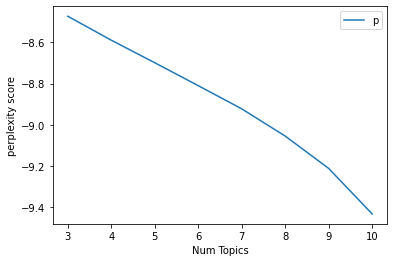

In [448]:
#general PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(general_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, general_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

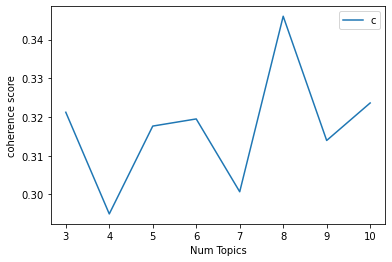

In [449]:
#general COHERENCE SCORE 
limit=3+len(general_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, general_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## GENERAL - 8 topic model

In [473]:
topic_1 = []
topic_1_string = ''

topic_2 = []
topic_2_string = ''

topic_3 = []
topic_3_string = ''

topic_4 = []
topic_4_string = ''

topic_5 = []
topic_5_string = ''

topic_6 = []
topic_6_string = ''

topic_7 = []
topic_7_string = ''

topic_8 = []
topic_8_string = ''

check1 = all_topics[6][0][1].split("\"")
check1 = [s.rstrip("*").lstrip(" + ") for s in check1]

check2 = all_topics[6][1][1].split("\"")
check2 = [s.rstrip("*").lstrip(" + ") for s in check2]

check3 = all_topics[6][2][1].split("\"")
check3 = [s.rstrip("*").lstrip(" + ") for s in check3]

check4 = all_topics[6][3][1].split("\"")
check4 = [s.rstrip("*").lstrip(" + ") for s in check4]

check5 = all_topics[6][4][1].split("\"")
check5 = [s.rstrip("*").lstrip(" + ") for s in check5]

check6 = all_topics[6][5][1].split("\"")
check6 = [s.rstrip("*").lstrip(" + ") for s in check6]

check7 = all_topics[6][6][1].split("\"")
check7 = [s.rstrip("*").lstrip(" + ") for s in check7]

check8 = all_topics[6][7][1].split("\"")
check8 = [s.rstrip("*").lstrip(" + ") for s in check8]

In [474]:
for i in range(20):
    topic_1.append((check1[(i*2)+1],check1[i*2]))
    topic_1_string += check1[(i*2)+1]
    topic_1_string += " "
    
    topic_2.append((check2[(i*2)+1],check2[i*2]))
    topic_2_string += check2[(i*2)+1]
    topic_2_string += " "
    
    topic_3.append((check3[(i*2)+1],check3[i*2]))
    topic_3_string += check3[(i*2)+1]
    topic_3_string += " "
    
    topic_4.append((check4[(i*2)+1],check4[i*2]))
    topic_4_string += check4[(i*2)+1]
    topic_4_string += " "
    
    topic_5.append((check5[(i*2)+1],check5[i*2]))
    topic_5_string += check5[(i*2)+1]
    topic_5_string += " "
    
    topic_6.append((check6[(i*2)+1],check6[i*2]))
    topic_6_string += check6[(i*2)+1]
    topic_6_string += " "
    
    topic_7.append((check7[(i*2)+1],check7[i*2]))
    topic_7_string += check7[(i*2)+1]
    topic_7_string += " "
    
    topic_8.append((check8[(i*2)+1],check8[i*2]))
    topic_8_string += check8[(i*2)+1]
    topic_8_string += " "

In [475]:
print("These are the words for 5 topics")
print("Perplexity score for 8-Topic model: ",general_perplexity_score[6])
print("Coherence score for 8-Topic model: ",general_coherence_score[6])
print(" ")
print("Topic 1: ",topic_1_string)
print(" ")
print("Topic 2: ",topic_2_string)
print(" ")
print("Topic 3: ",topic_3_string)
print(" ")
print("Topic 4: ",topic_4_string)
print(" ")
print("Topic 5: ",topic_5_string)
print(" ")
print("Topic 6: ",topic_6_string)
print(" ")
print("Topic 7: ",topic_7_string)
print(" ")
print("Topic 8: ",topic_8_string)

These are the words for 5 topics
Perplexity score for 8-Topic model:  -9.211170345152567
Coherence score for 8-Topic model:  0.3139398296330375
 
Topic 1:  community rarible right web3 create look marketplace purchase mona gift platform share appreciate perfect building unique gaming favorite always heart 
 
Topic 2:  piece art available liftoff live collector mint build edition start link early history keep get bullish chance release nftcommunity maybe 
 
Topic 3:  want make chain come real congrat people collect thing feel wear version limited invest well wallet hear cool drip issue 
 
Topic 4:  digitalax digitalfashion support read man take excited game high article completely nftcollector incredible huge win network content list show reach 
 
Topic 5:  collection love think collectible owner cryptojeweler new ready pendant crypto opensea luxury utility skin announce continue investment bring message digifizzy 
 
Topic 6:  jewelry digital fashion future world big brand begin blockch

In [450]:
pyLDAvis.save_html(all_vis[6], 'all_lda_vis7.html')

## COMPILER LDA

In [451]:
compiler_topics = []
compiler_perplexity_score = []
compiler_coherence_score = []
compiler_vis = []

for i in range(3,11):
    compiler_lda_model = gensim.models.ldamodel.LdaModel(corpus=compiler_corpus,
                                           id2word=compiler_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    compiler_topics.append(compiler_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    compiler_perplexity_score.append(compiler_lda_model.log_perplexity(compiler_corpus))
    
    coherence_model_lda = CoherenceModel(model=compiler_lda_model, texts=compiler_lemmatized, dictionary=compiler_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    compiler_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(compiler_lda_model, compiler_corpus, compiler_id2word)
    compiler_vis.append(vis_i)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [452]:
compiler_topics

[[(0,
   '0.022*"eye" + 0.017*"community" + 0.013*"mint" + 0.013*"support" + 0.013*"welcome" + 0.013*"holder" + 0.013*"piece" + 0.013*"make" + 0.013*"inspiration" + 0.009*"bring" + 0.009*"style" + 0.009*"collection" + 0.009*"nftcommunity" + 0.009*"time" + 0.009*"start" + 0.009*"big" + 0.009*"purchase" + 0.009*"amazing" + 0.009*"upcoming" + 0.009*"ready" + 0.009*"artist" + 0.009*"custom" + 0.005*"look" + 0.005*"receive" + 0.005*"physical" + 0.005*"focus" + 0.005*"illustration" + 0.005*"inspire" + 0.005*"tune" + 0.005*"rather"'),
  (1,
   '0.032*"eye" + 0.030*"vibrant" + 0.027*"colorful" + 0.027*"hand" + 0.027*"draw" + 0.026*"trait" + 0.024*"belittle" + 0.024*"industry" + 0.024*"judge" + 0.024*"fun" + 0.024*"contrast" + 0.018*"create" + 0.018*"style" + 0.015*"art" + 0.015*"bring" + 0.012*"inspired" + 0.012*"begin" + 0.012*"artist" + 0.012*"collection" + 0.012*"inspire" + 0.009*"public" + 0.009*"mint" + 0.009*"work" + 0.009*"forbe" + 0.007*"shopping" + 0.007*"presale" + 0.007*"excited" + 

In [453]:
compiler_vis[0]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.133380  0.025464       1        1  45.237339
1      0.039422 -0.106149       2        1  34.231322
0      0.093958  0.080685       3        1  20.531339, topic_info=             Term      Freq     Total Category  logprob  loglift
52       belittle  6.000000  6.000000  Default  30.0000  30.0000
60       industry  6.000000  6.000000  Default  29.0000  29.0000
62          judge  6.000000  6.000000  Default  28.0000  28.0000
57            fun  6.000000  6.000000  Default  27.0000  27.0000
54       contrast  6.000000  6.000000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
65          focus  0.813672  2.089488   Topic3  -5.2242   0.6401
70   illustration  0.813626  2.868956   Topic3  -5.2243   0.3230
83        inspire  0.813609  4.178065   Topic3  -5.2243  -0.0529
262          tune  0.813594  2.742982   Topic3  -5.2243   0.3679
68         rather  0.813244  2.089605   Topic3  -5.2247   0.6395

[183 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
119       1  0.885149           access
143       2  0.596570          amazing
143       3  0.298285          amazing
121       1  0.343276         announce
121       2  0.686551         announce
...     ...       ...              ...
25        3  0.225809            woman
108       2  0.728889       womeninnft
108       3  0.364444       womeninnft
181       2  0.698439             work
218       2  0.705253  worldofwomennft

[190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

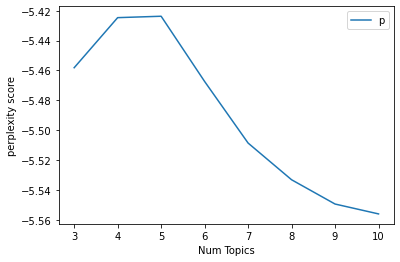

In [454]:
#compiler PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(compiler_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, compiler_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

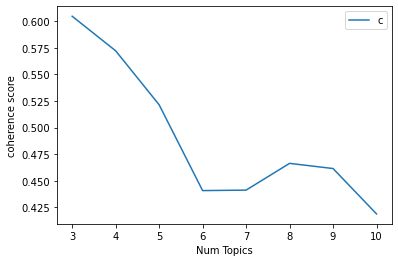

In [455]:
#compiler COHERENCE SCORE 
limit=3+len(compiler_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, compiler_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [ ]:
pyLDAvis.save_html(all_vis[6], 'all_lda_vis7.html')

## VOGUE LDA

In [456]:
vogue_topics = []
vogue_perplexity_score = []
vogue_coherence_score = []
vogue_vis = []

for i in range(3,11):
    vogue_lda_model = gensim.models.ldamodel.LdaModel(corpus=vogue_corpus,
                                           id2word=vogue_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    vogue_topics.append(vogue_lda_model.show_topics(num_topics=i,num_words=20))
    
    vogue_perplexity_score.append(vogue_lda_model.log_perplexity(vogue_corpus))
    
    coherence_model_lda = CoherenceModel(model=vogue_lda_model, texts=vogue_lemmatized, dictionary=vogue_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    vogue_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(vogue_lda_model, vogue_corpus, vogue_id2word)
    vogue_vis.append(vis_i)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [457]:
vogue_topics

[[(0,
   '0.042*"ukraine" + 0.033*"collection" + 0.032*"child" + 0.032*"save" + 0.032*"proceed" + 0.032*"sale" + 0.031*"peace" + 0.029*"dress" + 0.019*"live" + 0.016*"go" + 0.015*"design" + 0.013*"flame" + 0.013*"available" + 0.012*"sgt" + 0.010*"virtual" + 0.010*"artwork" + 0.009*"model" + 0.009*"depict" + 0.009*"feature" + 0.009*"antarctic"'),
  (1,
   '0.027*"vogue" + 0.021*"live" + 0.021*"join" + 0.020*"art" + 0.019*"sgt" + 0.019*"available" + 0.015*"voguesingapore" + 0.015*"cover" + 0.014*"chat" + 0.014*"voguenftissue" + 0.014*"artist" + 0.014*"reminder" + 0.014*"auction" + 0.011*"collection" + 0.008*"historic" + 0.008*"baelfdesign" + 0.008*"voguenft" + 0.008*"pm" + 0.008*"altavagroup" + 0.008*"movement"'),
  (2,
   '0.041*"vogue" + 0.020*"box" + 0.017*"mystery" + 0.012*"artist" + 0.012*"city" + 0.012*"drop" + 0.012*"chance" + 0.012*"cover" + 0.010*"available" + 0.009*"collection" + 0.009*"partnership" + 0.009*"month" + 0.009*"create" + 0.009*"issue" + 0.009*"purchase" + 0.008*"vo

In [472]:
vogue_vis[2]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.122234 -0.092660       1        1  37.190229
4     -0.176410 -0.014498       2        1  32.521302
3      0.061614  0.158991       3        1  13.625317
1      0.051436 -0.036978       4        1   9.434214
0     -0.058873 -0.014855       5        1   7.228938, topic_info=          Term       Freq      Total Category  logprob  loglift
13     ukraine  12.000000  12.000000  Default  30.0000  30.0000
28       dress   7.000000   7.000000  Default  29.0000  29.0000
12        save   9.000000   9.000000  Default  28.0000  28.0000
3        child   9.000000   9.000000  Default  27.0000  27.0000
10     proceed   9.000000   9.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
10     proceed   0.962054   9.225779   Topic5  -3.8541   0.3664
9        peace   0.962164   9.227034   Topic5  -3.8540   0.3664
11        sale   0.961994   9.225798   Topic5  -3.8542   0.3663
13     ukraine   0.962401  12.319557   Topic5  -3.8538   0.0776
4   collection   0.963300  12.604327   Topic5  -3.8529   0.0556

[232 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
97        3  0.822095       advice
132       1  0.901488    afterlife
212       4  0.889029  altavagroup
203       3  0.822095    animation
119       1  0.901488       answer
...     ...       ...          ...
81        3  0.822095         week
69        5  0.944775        white
200       1  0.311388          win
200       3  0.622776          win
117       3  0.822095         word

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

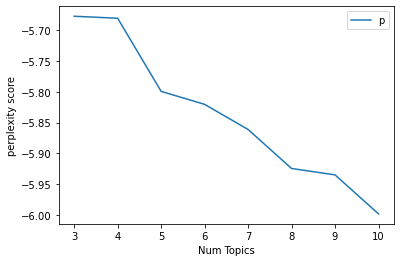

In [459]:
#vogue PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(vogue_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, vogue_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

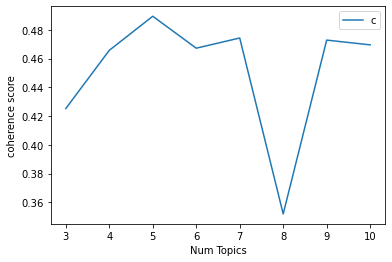

In [460]:
#vogue COHERENCE SCORE 
limit=3+len(vogue_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, vogue_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [ ]:
pyLDAvis.save_html(all_vis[6], 'all_lda_vis7.html')

## MEDIA, CREATOR PROCESSING

In [216]:
#MEDIA
media_bigram = gensim.models.Phrases(media_words, min_count=5, threshold=100)
media_trigram = gensim.models.Phrases(media_bigram[media_words], threshold=100)  

media_bigram_mod = gensim.models.phrases.Phraser(media_bigram)
media_trigram_mod = gensim.models.phrases.Phraser(media_trigram)

print(media_trigram_mod[media_bigram_mod[media_words[0]]])

#CREATOR
creator_bigram = gensim.models.Phrases(creator_words, min_count=5, threshold=100)
creator_trigram = gensim.models.Phrases(creator_bigram[creator_words], threshold=100)  

creator_bigram_mod = gensim.models.phrases.Phraser(creator_bigram)
creator_trigram_mod = gensim.models.phrases.Phraser(creator_trigram)

print(creator_trigram_mod[creator_bigram_mod[creator_words[0]]])

['launches', 'frequent', 'brands', 'including', 'gucci', 'adidas', 'launching', 'according', 'new', 'data', 'retail', 'consumers', 'across', 'uk', 'us', 'unaware', 'applications', 'benefits']
['inspired', 'profound', 'desire', 'explore', 'new', 'playgrounds', 'vault', 'recently', 'chose', 'acquire', 'parcels', 'land', 'sandbox', 'voxel', 'voxel', 'bespoke', 'world', 'become', 'eclectic', 'space', 'fostering', 'boundary', 'pushing', 'creativity']


In [220]:
#MEDIA
def make_bigrams1(texts):
    return [media_bigram_mod[doc] for doc in texts]
def make_trigrams1(texts):
    return [media_trigram_mod[media_bigram_mod[doc]] for doc in texts]

#CREATOR
def make_bigrams2(texts):
    return [creator_bigram_mod[doc] for doc in texts]
def make_trigrams2(texts):
    return [creator_trigram_mod[creator_bigram_mod[doc]] for doc in texts]

In [225]:
#BIGRAMS
media_bigrams = make_bigrams1(media_words)
media_lemmatized = lemmatization(media_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

creator_bigrams = make_bigrams2(creator_words)
creator_lemmatized = lemmatization(creator_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(media_lemmatized[:1])

[['launch', 'frequent', 'brand', 'include', 'adida', 'launch', 'accord', 'new', 'datum', 'retail', 'consumer', 'unaware', 'application', 'benefit']]


In [ ]:
media_id2word = corpora.Dictionary(media_lemmatized)
creator_id2word = corpora.Dictionary(creator_lemmatized)

media_texts = media_lemmatized
creator_texts = creator_lemmatized

media_corpus = [media_id2word.doc2bow(text) for text in media_texts]
creator_corpus = [creator_id2word.doc2bow(text) for text in creator_texts]

## MEDIA LDA

In [ ]:
media_topics = []
media_perplexity_score = []
media_coherence_score = []
media_vis = []

for i in range(3,11):
    media_lda_model = gensim.models.ldamodel.LdaModel(corpus=media_corpus,
                                           id2word=media_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    media_topics.append(media_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    media_perplexity_score.append(media_lda_model.log_perplexity(media_corpus))
    
    coherence_model_lda = CoherenceModel(model=media_lda_model, texts=media_lemmatized, dictionary=media_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    media_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(media_lda_model, media_corpus, media_id2word)
    media_vis.append(vis_i)

In [ ]:
media_topics

In [ ]:
media_vis[0]

In [ ]:
#MEDIA PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(media_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, media_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# MEDIA COHERENCE SCORE 
limit=3+len(media_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, media_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## CREATOR LDA

In [ ]:
creator_topics = []
creator_perplexity_score = []
creator_coherence_score = []
creator_vis = []

for i in range(3,11):
    creator_lda_model = gensim.models.ldamodel.LdaModel(corpus=creator_corpus,
                                           id2word=creator_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    creator_topics.append(creator_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    creator_perplexity_score.append(creator_lda_model.log_perplexity(creator_corpus))
    
    coherence_model_lda = CoherenceModel(model=creator_lda_model, texts=creator_lemmatized, dictionary=creator_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    creator_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(creator_lda_model, creator_corpus, creator_id2word)
    creator_vis.append(vis_i)

In [ ]:
creator_topics

In [ ]:
creator_vis[0]

In [ ]:
#CREATOR PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(creator_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, creator_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
#CREATOR COHERENCE SCORE 
limit=3+len(creator_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, creator_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()